#### Imports

In [62]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import numpy as np

from sklearn.decomposition import PCA
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

print("All libraries are successfully imported!")

All libraries are successfully imported!


#### Extract Dataset

In [3]:
# Read the CSV file
file_path = os.path.join(os.getcwd(), "database.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_pos = df['pos_url']
image_neg = df['neg_url']

new_df = pd.DataFrame({
    'sentence': sentence,
    'image_pos': image_pos,
    'image_neg': image_neg
})

new_df.head()


,sentence,image_pos,image_neg
0,man stand behind the wall,https://previews.123rf.com/images/ryanking999/...,https://previews.123rf.com/images/ryanking999/...
1,The woman is sitting against the wall.,http://www.colourbox.com/preview/5020075-52275...,https://st4.depositphotos.com/1462687/20482/i/...
2,Man doing exercise sits in front of a wall,https://hips.hearstapps.com/hmg-prod.s3.amazon...,https://previews.123rf.com/images/ryanking999/...
3,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://thumbs.dreamstime.com/z/%E5%9C%A8%E7%8...
4,A man is standing on a wall.,https://previews.123rf.com/images/deagreez/dea...,https://image.shutterstock.com/z/stock-photo-1...


#### Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


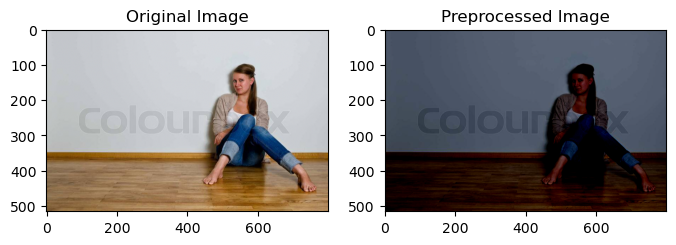

Feature Vector Positive : [ 2.5502552e-06  6.1817218e-13  1.5987212e-13 -4.7961635e-14
 -4.9737992e-14 -1.3216095e-12  7.1054274e-15 -5.5067062e-14
  8.1712415e-14 -6.9944051e-15 -1.4988011e-14 -8.1315163e-19
 -5.8233515e-22  2.0162527e-24  8.4818325e-27  7.2701421e-27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


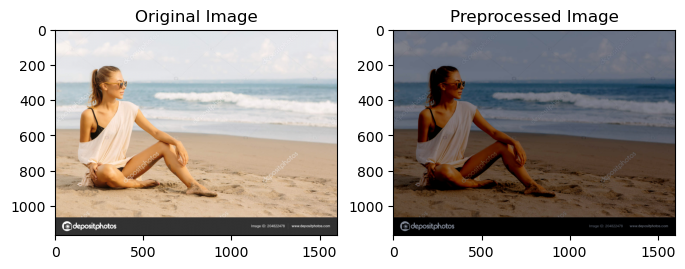

Feature Vector Negatice : [ 2.66032112e-06 -3.41948692e-13  1.31450406e-13  1.16712195e-14
 -3.55271368e-15 -9.76996262e-15  0.00000000e+00  4.44089210e-14
  1.59872116e-14 -1.57859836e-16  1.26374605e-15  5.00728821e-19
 -2.53666939e-16 -6.36135185e-19  3.81639165e-17  1.31838984e-16]


In [63]:
def download_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content))
    return img

def extract_features(img):
    # Load and preprocess the image
    img_data = image.img_to_array(img)
    img_data_expanded = np.expand_dims(img_data, axis=0)
    img_data_preprocessed = preprocess_input(img_data_expanded)

    # Extract features
    features = base_model.predict(img_data_preprocessed)
    return img, img_data, features

def pca_image(img, n_components):
    img_path = download_image(img)
    original_img, preprocessed_img, features = extract_features(img_path)

    # Convert original image to numpy array for display
    original_img_array = np.array(original_img)

    # Plot the original image
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img_array / 255.0)

    # Plot the preprocessed image
    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Image")
    plt.imshow(preprocessed_img / 255.0)

    plt.show()

    # Print the entire feature vector
    # print("Feature shape: ", features.shape)
    # print("Extracted features:", features.flatten())
    # print("Number of features:", len(features.flatten()))
    # print(f"Feature vector: {features.shape}")

    # Get the shape of the feature vector
    num_samples, num_features = features.shape

    # print("Number of samples:", num_samples)
    # print("Number of features:", num_features)

    # Define the PCA object
    pca = PCA(n_components=n_components)

    replicated_feature_vector = np.tile(features, (n_components, 1))
    pca.fit(replicated_feature_vector)
    reduced_vector = pca.transform(features)

    # print("\nOriginal shape:", features.shape)
    # print(f"Original Vector: ", features)

    # print("\nReduced shape:", reduced_vector.shape)
    reshaped_tensor = reduced_vector.reshape(-1)
    # print(f"Reduced Vector: ", reshaped_tensor)

    return reshaped_tensor

# Load the ResNet50 model pre-trained on ImageNet, excluding the final layers to make it suitable for features not classification
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

feature_vec_pos = pca_image(new_df["image_pos"][1], 16)
print(f"Feature Vector Positive : {feature_vec_pos}")

feature_vec_neg = pca_image(new_df["image_neg"][1], 16)
print(f"Feature Vector Negatice : {feature_vec_neg}")


#### Create two seperate ansatz image circuit

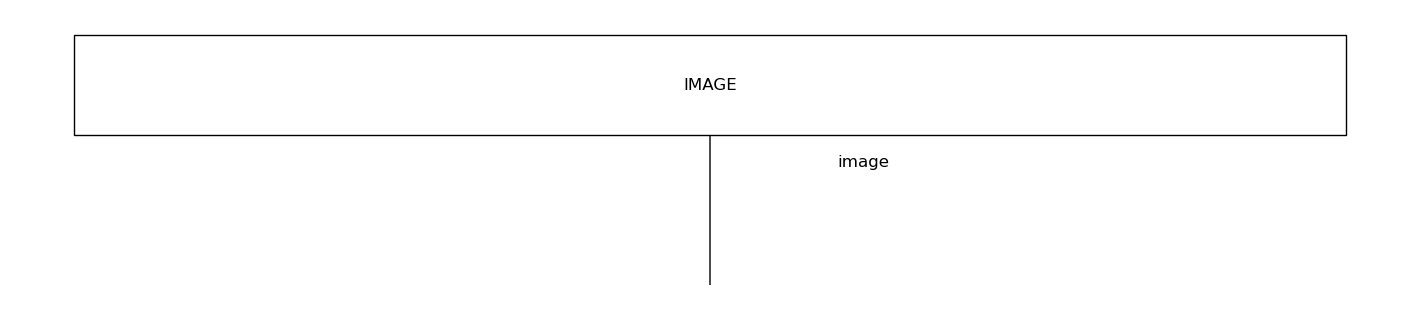

{IMAGE__image_8, IMAGE__image_6, IMAGE__image_10, IMAGE__image_14, IMAGE__image_5, IMAGE__image_3, IMAGE__image_2, IMAGE__image_12, IMAGE__image_15, IMAGE__image_0, IMAGE__image_9, IMAGE__image_4, IMAGE__image_11, IMAGE__image_7, IMAGE__image_1, IMAGE__image_13}
[ 2.5502552e-06  6.1817218e-13  1.5987212e-13 -4.7961635e-14
 -4.9737992e-14 -1.3216095e-12  7.1054274e-15 -5.5067062e-14
  8.1712415e-14 -6.9944051e-15 -1.4988011e-14 -8.1315163e-19
 -5.8233515e-22  2.0162527e-24  8.4818325e-27  7.2701421e-27]


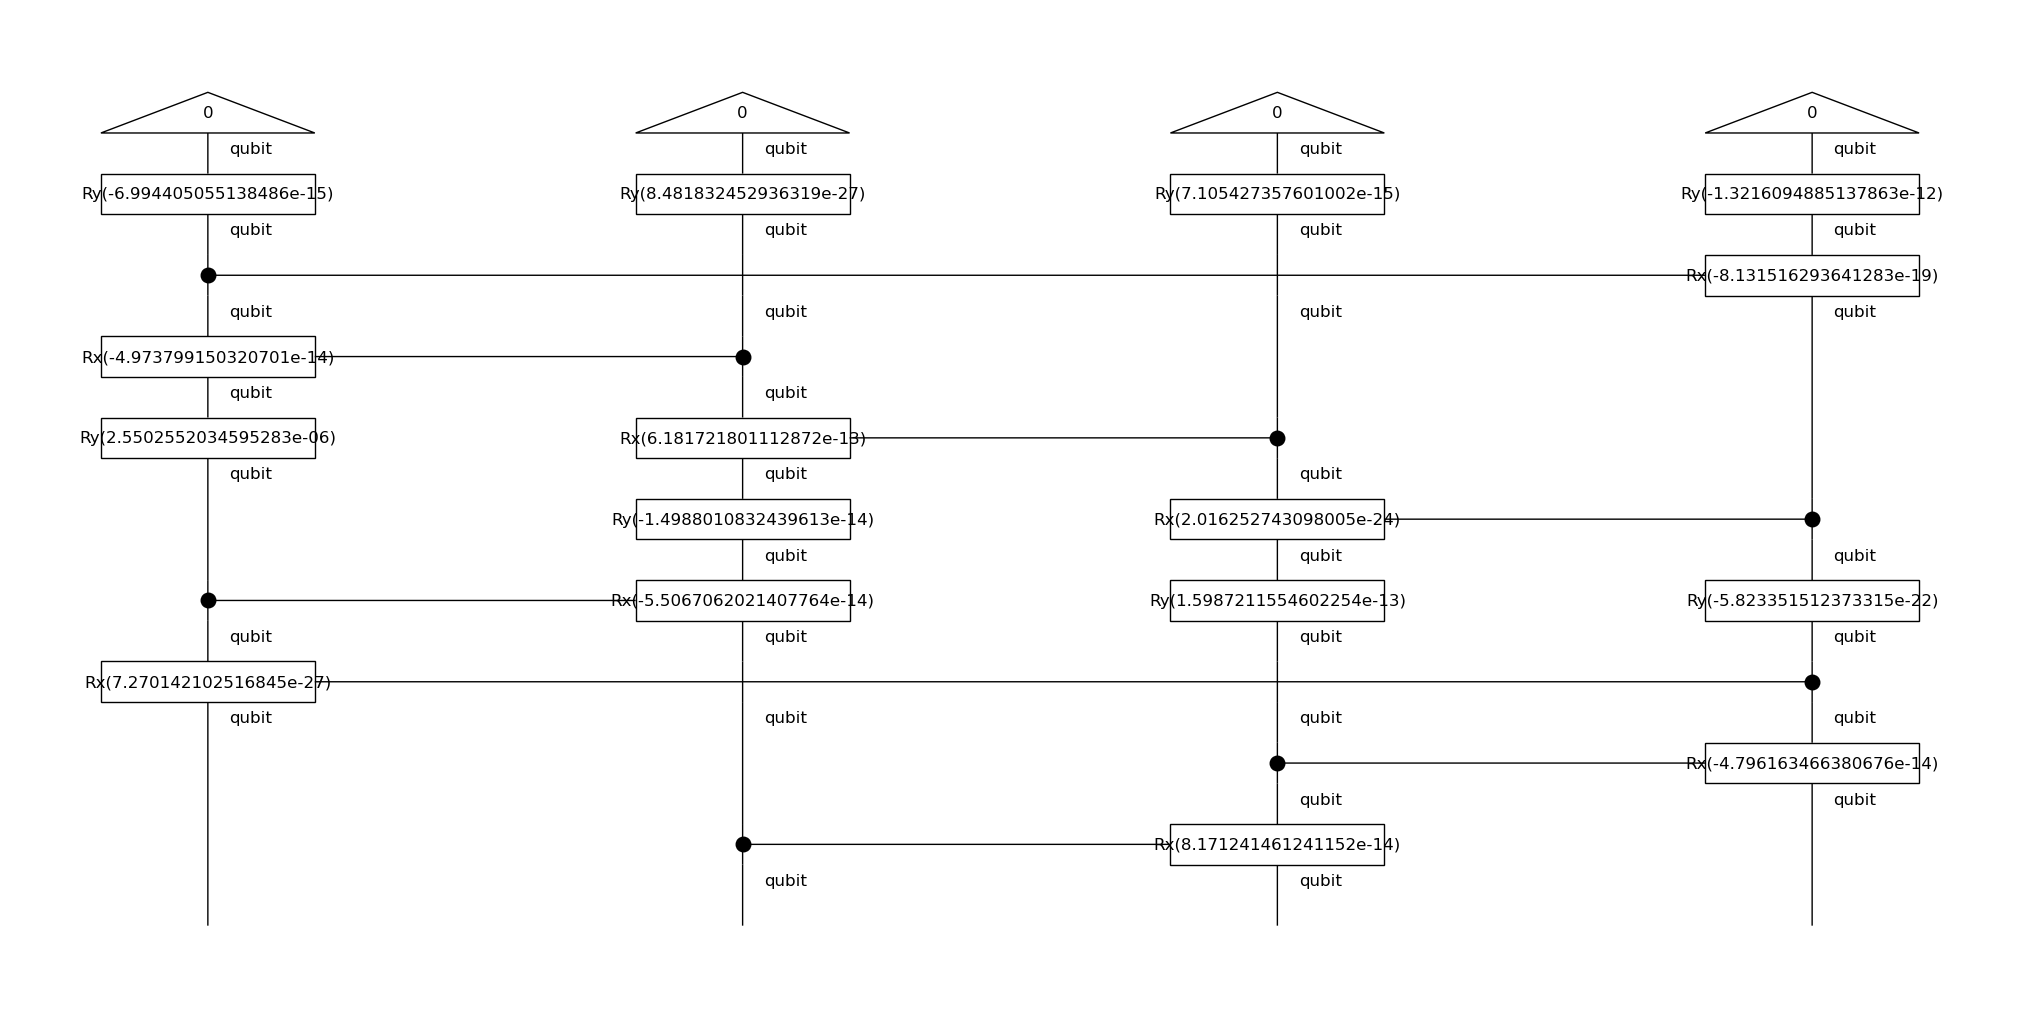

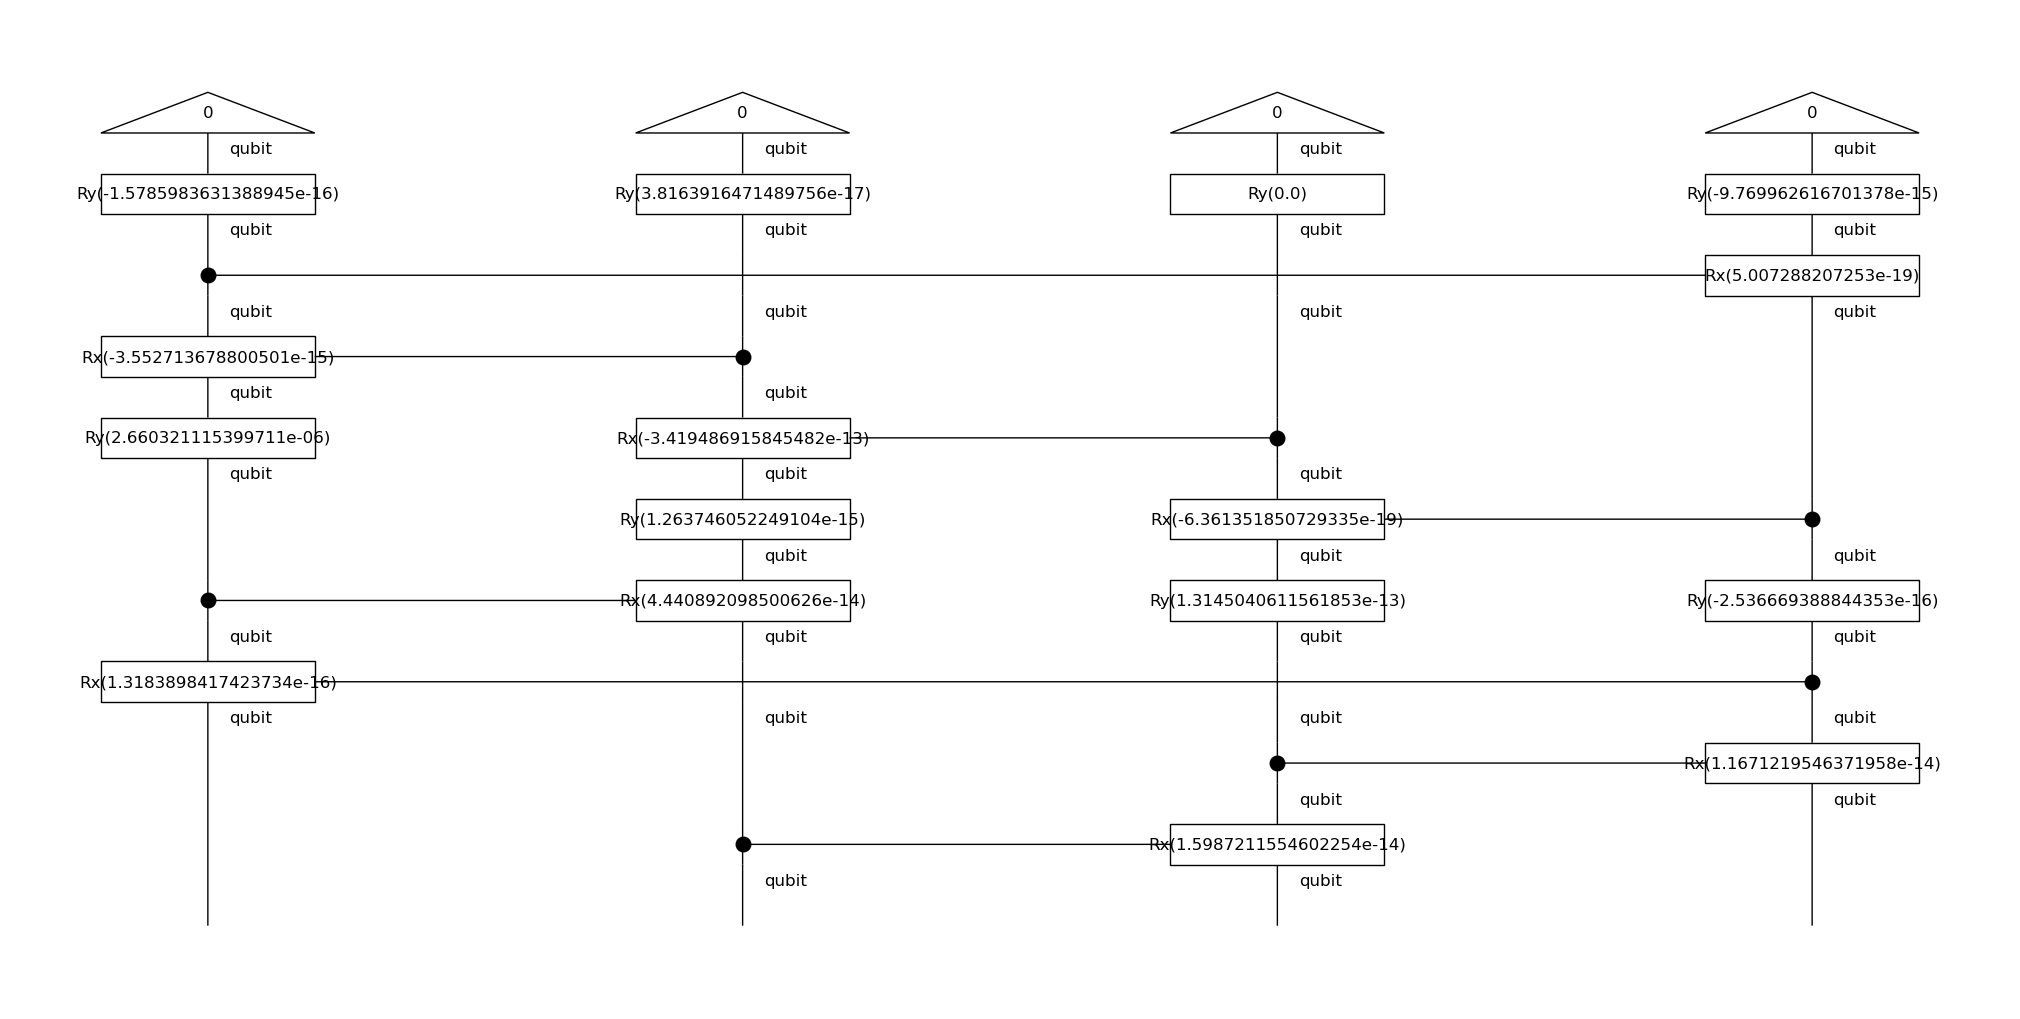

In [64]:
from lambeq.backend.grammar import Ty, Box 
from lambeq import Sim14Ansatz
from torch import nn

# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
# image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POS
conc_image_circ_pos = image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec_pos) 
conc_image_circ_pos.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit NEG
conc_image_circ_neg = image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec_neg) 
conc_image_circ_neg.draw(figsize=(20, 10), fontsize=12)

#### Sentence DisCoCat 

this is in a quantum setting but it might be more efficient in a a tesnor setting

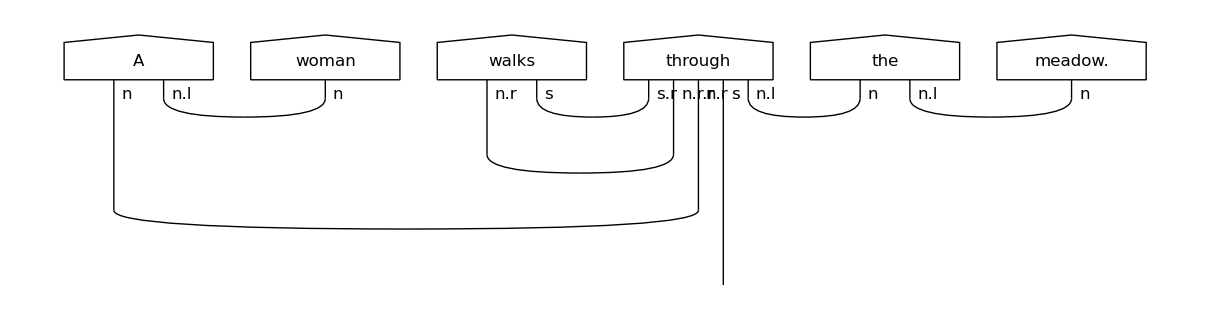

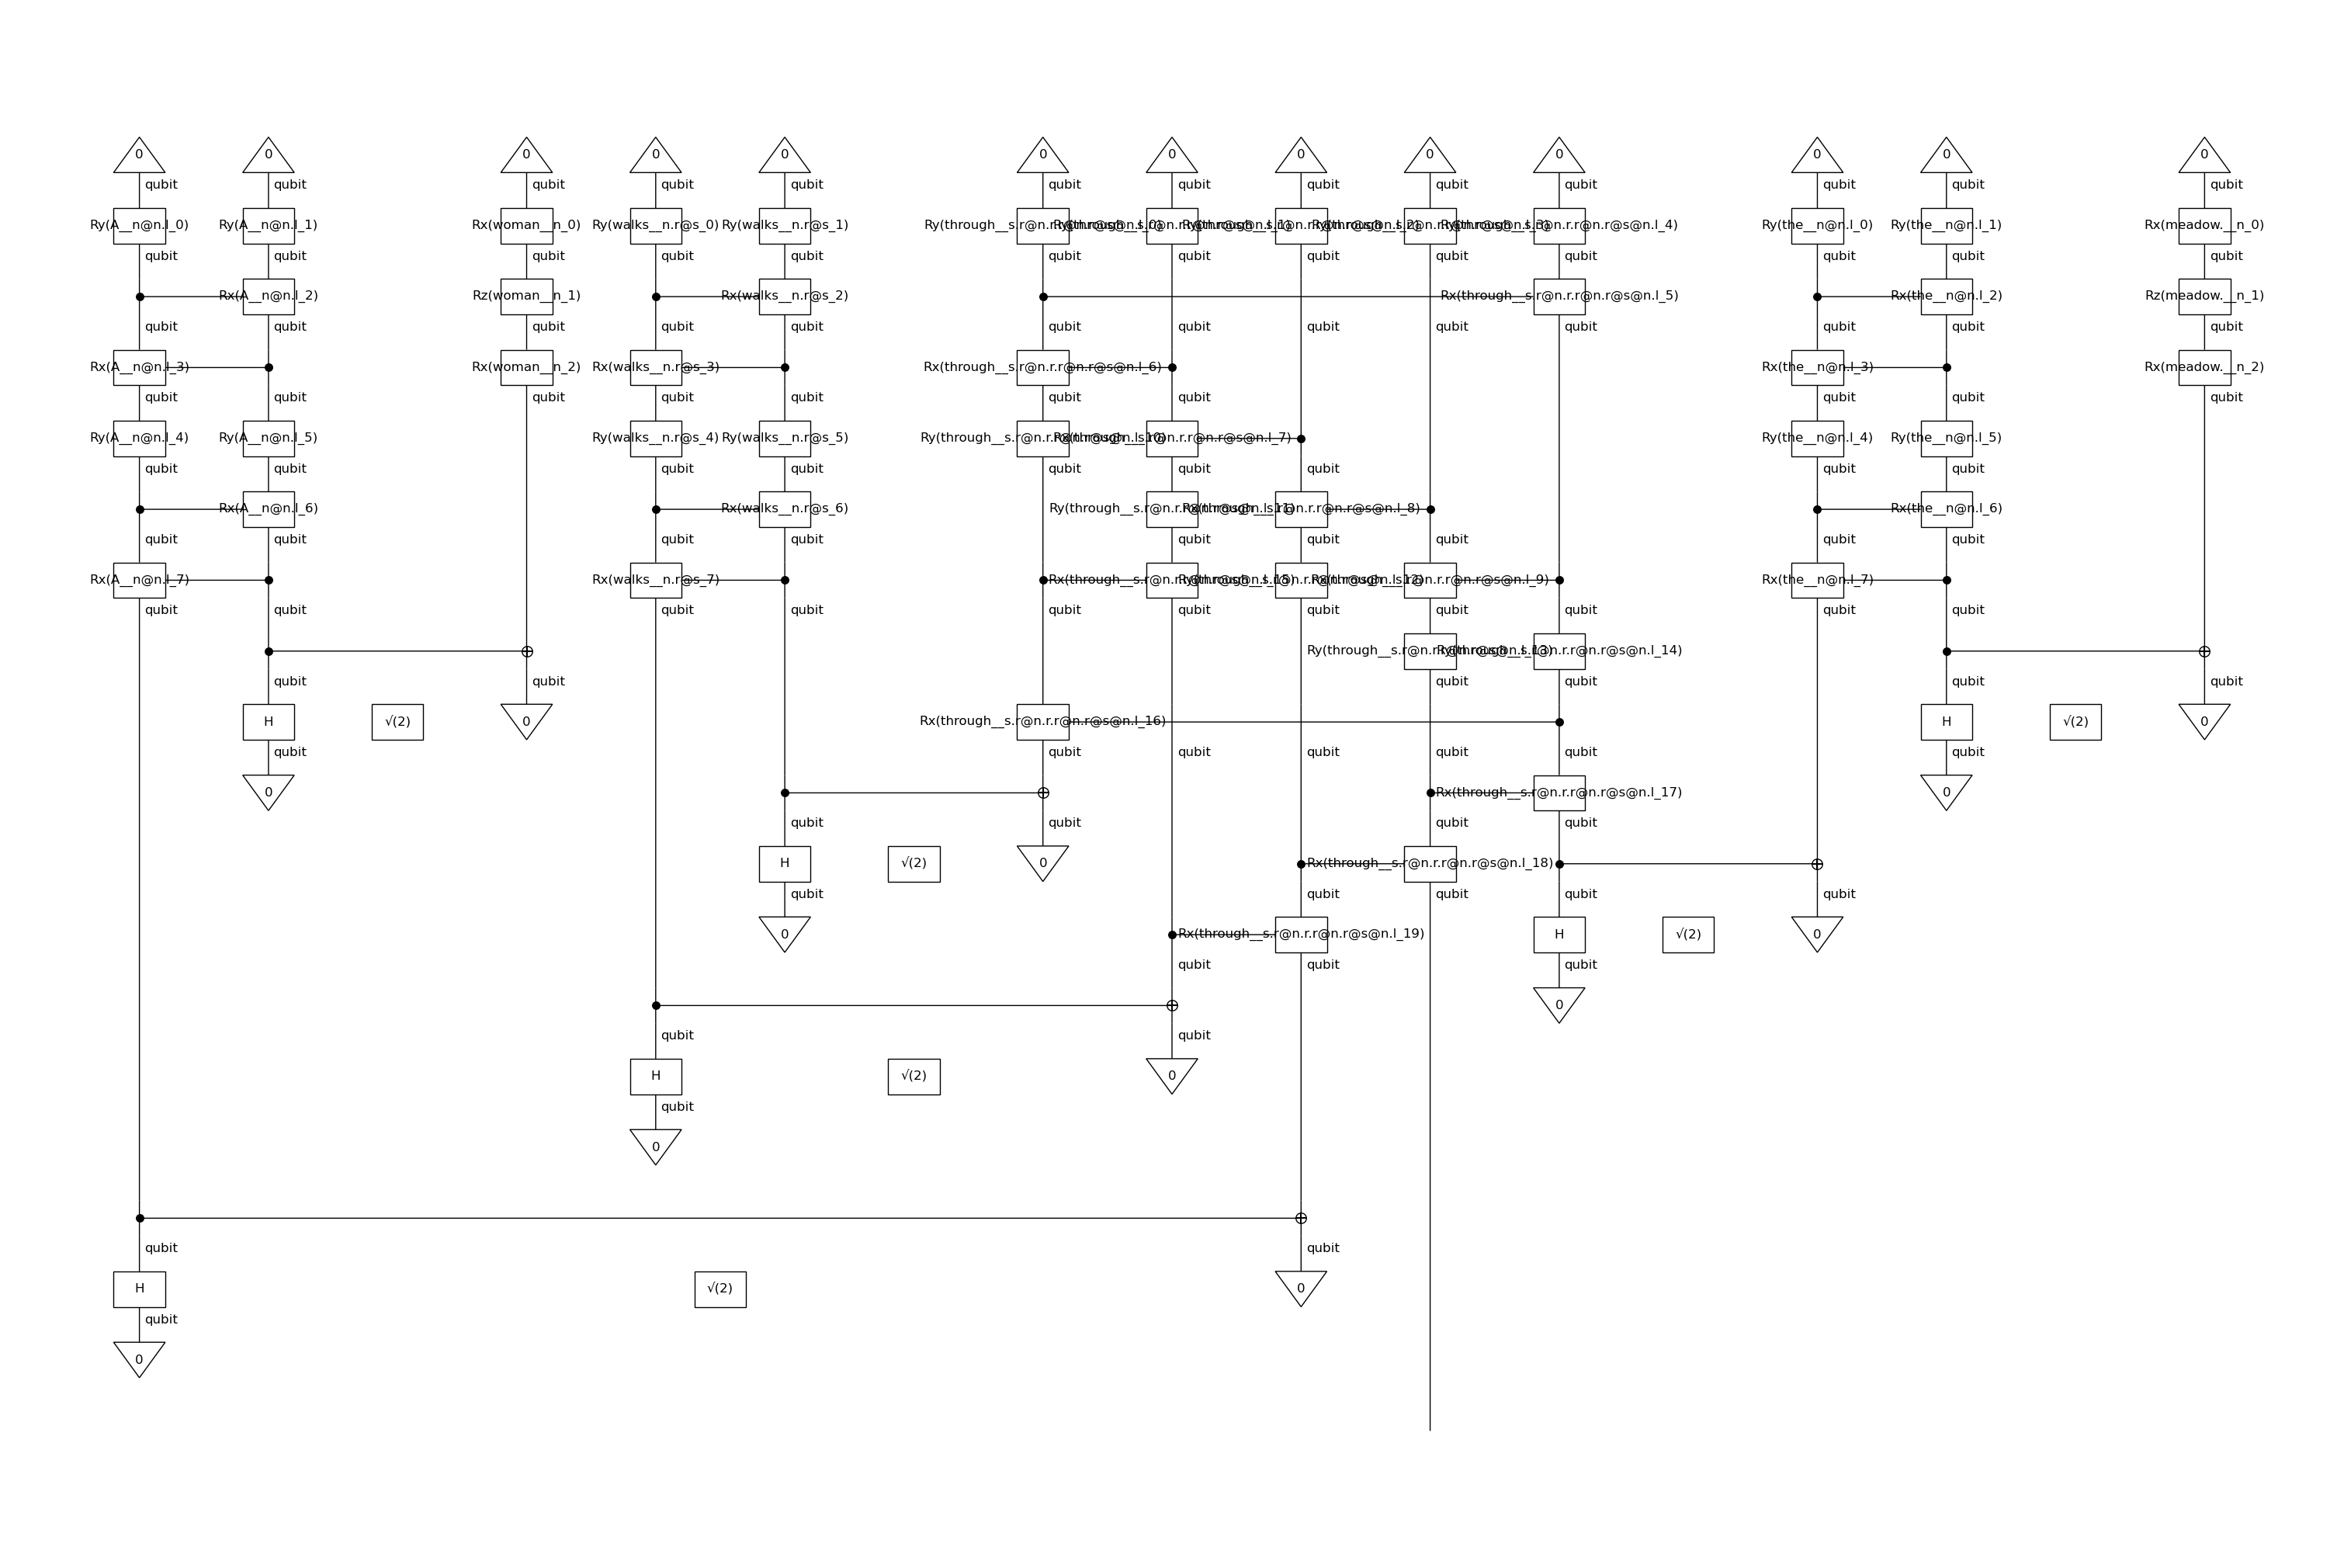

In [11]:
from lambeq import BobcatParser, AtomicType

# Parse the sentence and convert it into a string diagram
sentence = new_df["sentence"][14]

# Use BobbcatParser
parser = BobcatParser(verbose='suppress')
sentence_diagram = parser.sentence2diagram(sentence)
sentence_diagram.draw(figsize=(14, 3), fontsize=12)

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},n_layers=1)
conc_sentence = ansatz_sentence(sentence_diagram)

conc_sentence.draw(figsize=(30, 20), fontsize=12)

#### Joined Circuits

Template diagram : (sentence, image1, image2)


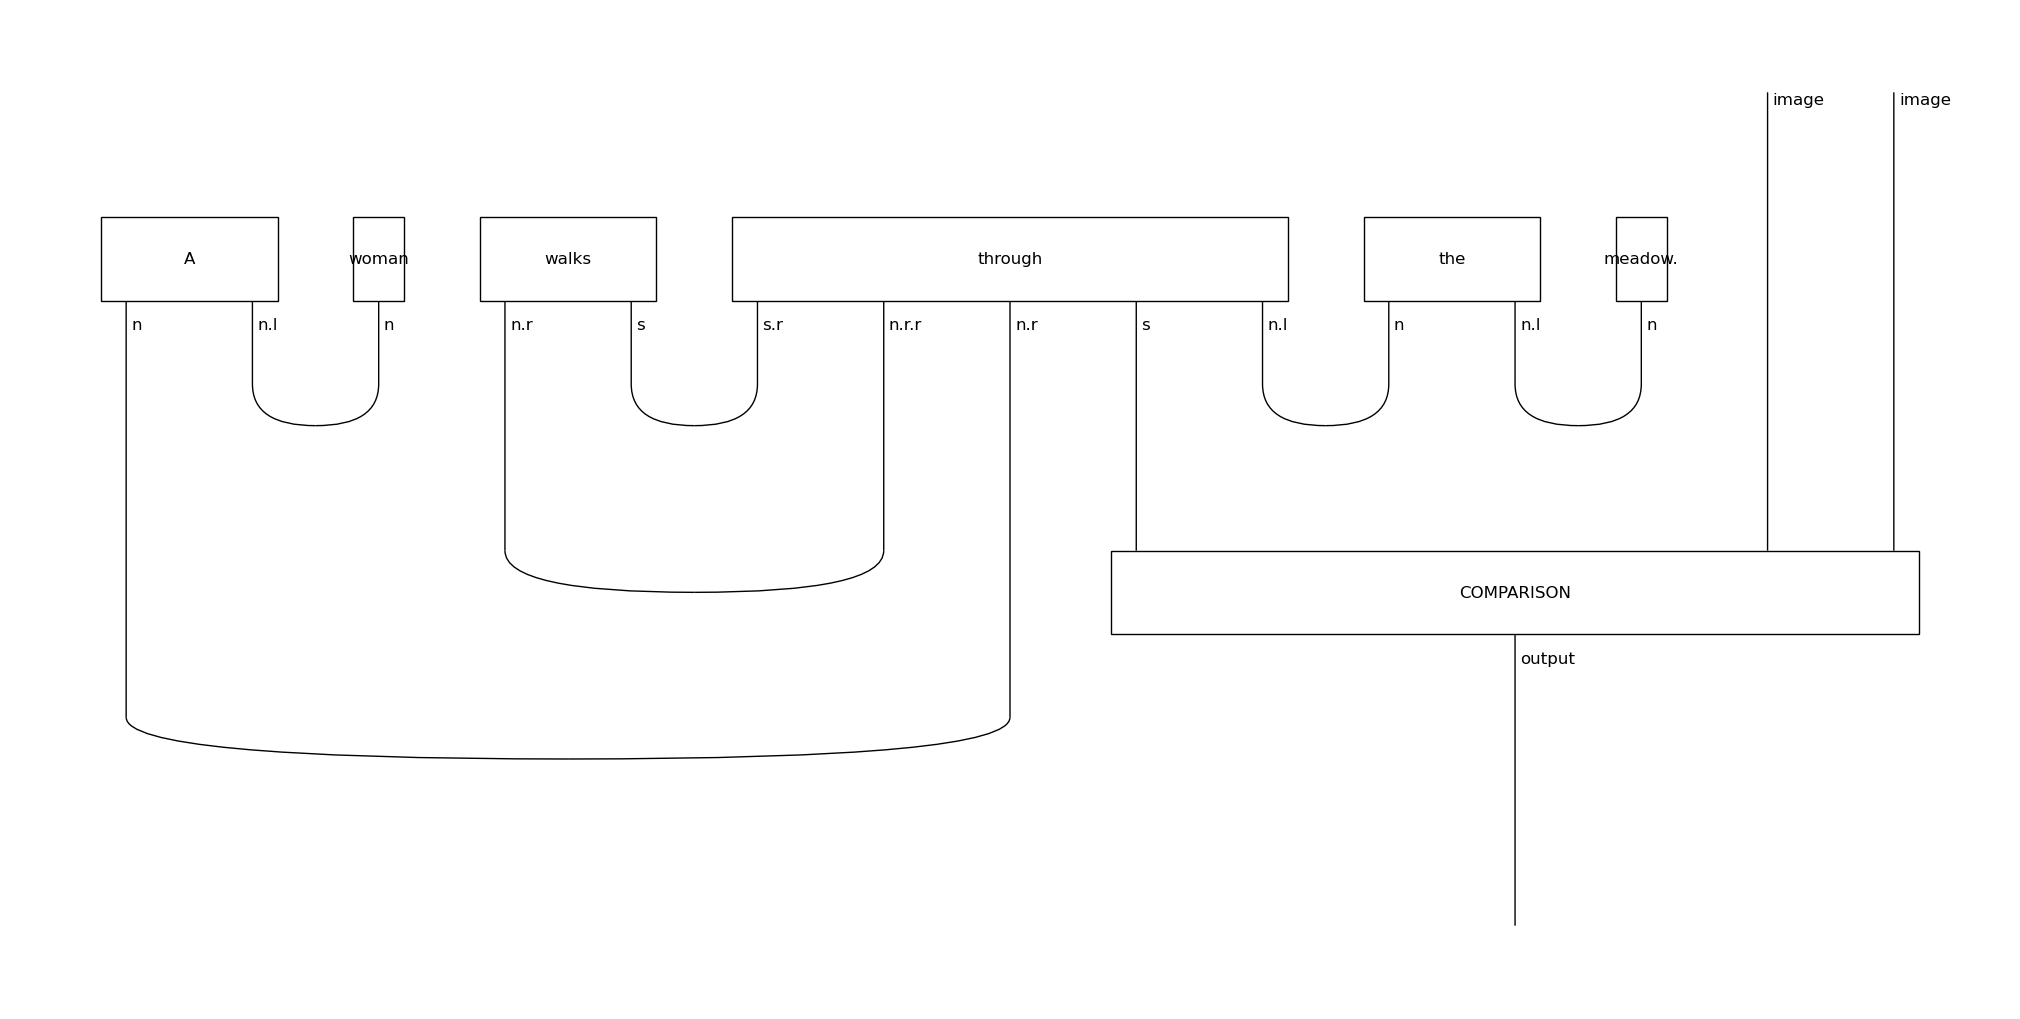

Template circuit : (sentence, image_type , image_type)


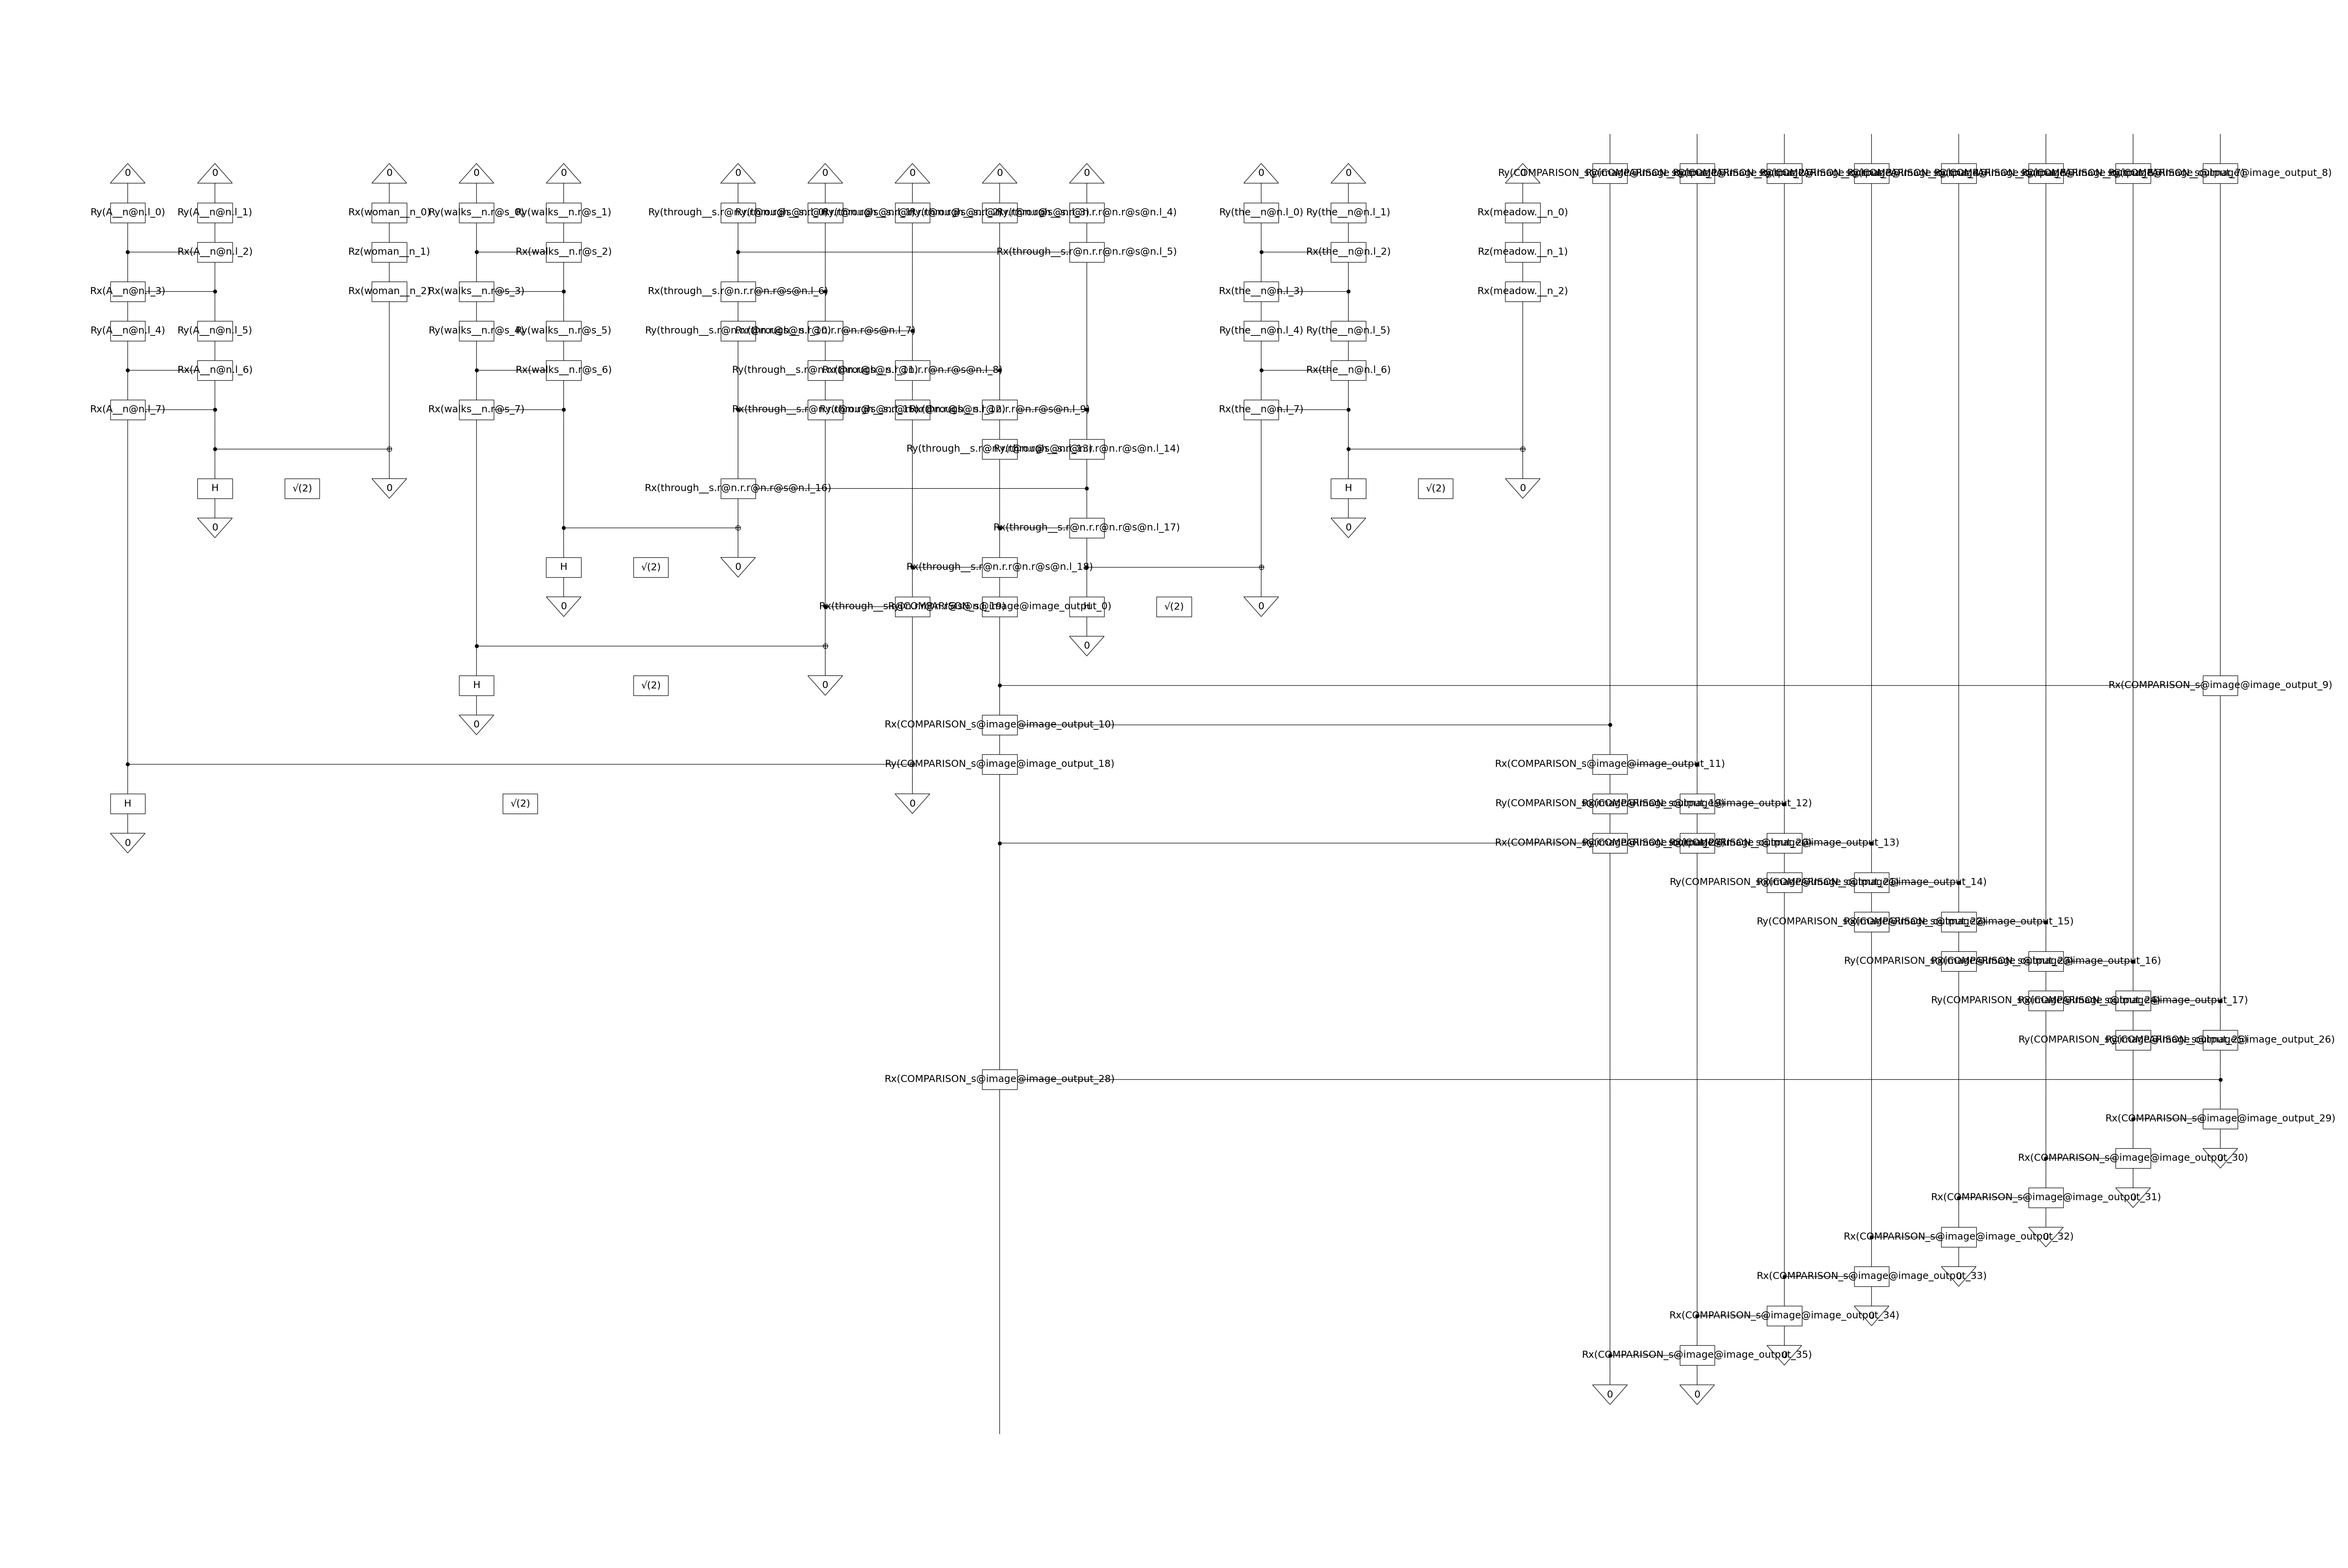

Quantum circuit : (sentence, image data pos , image data neg)


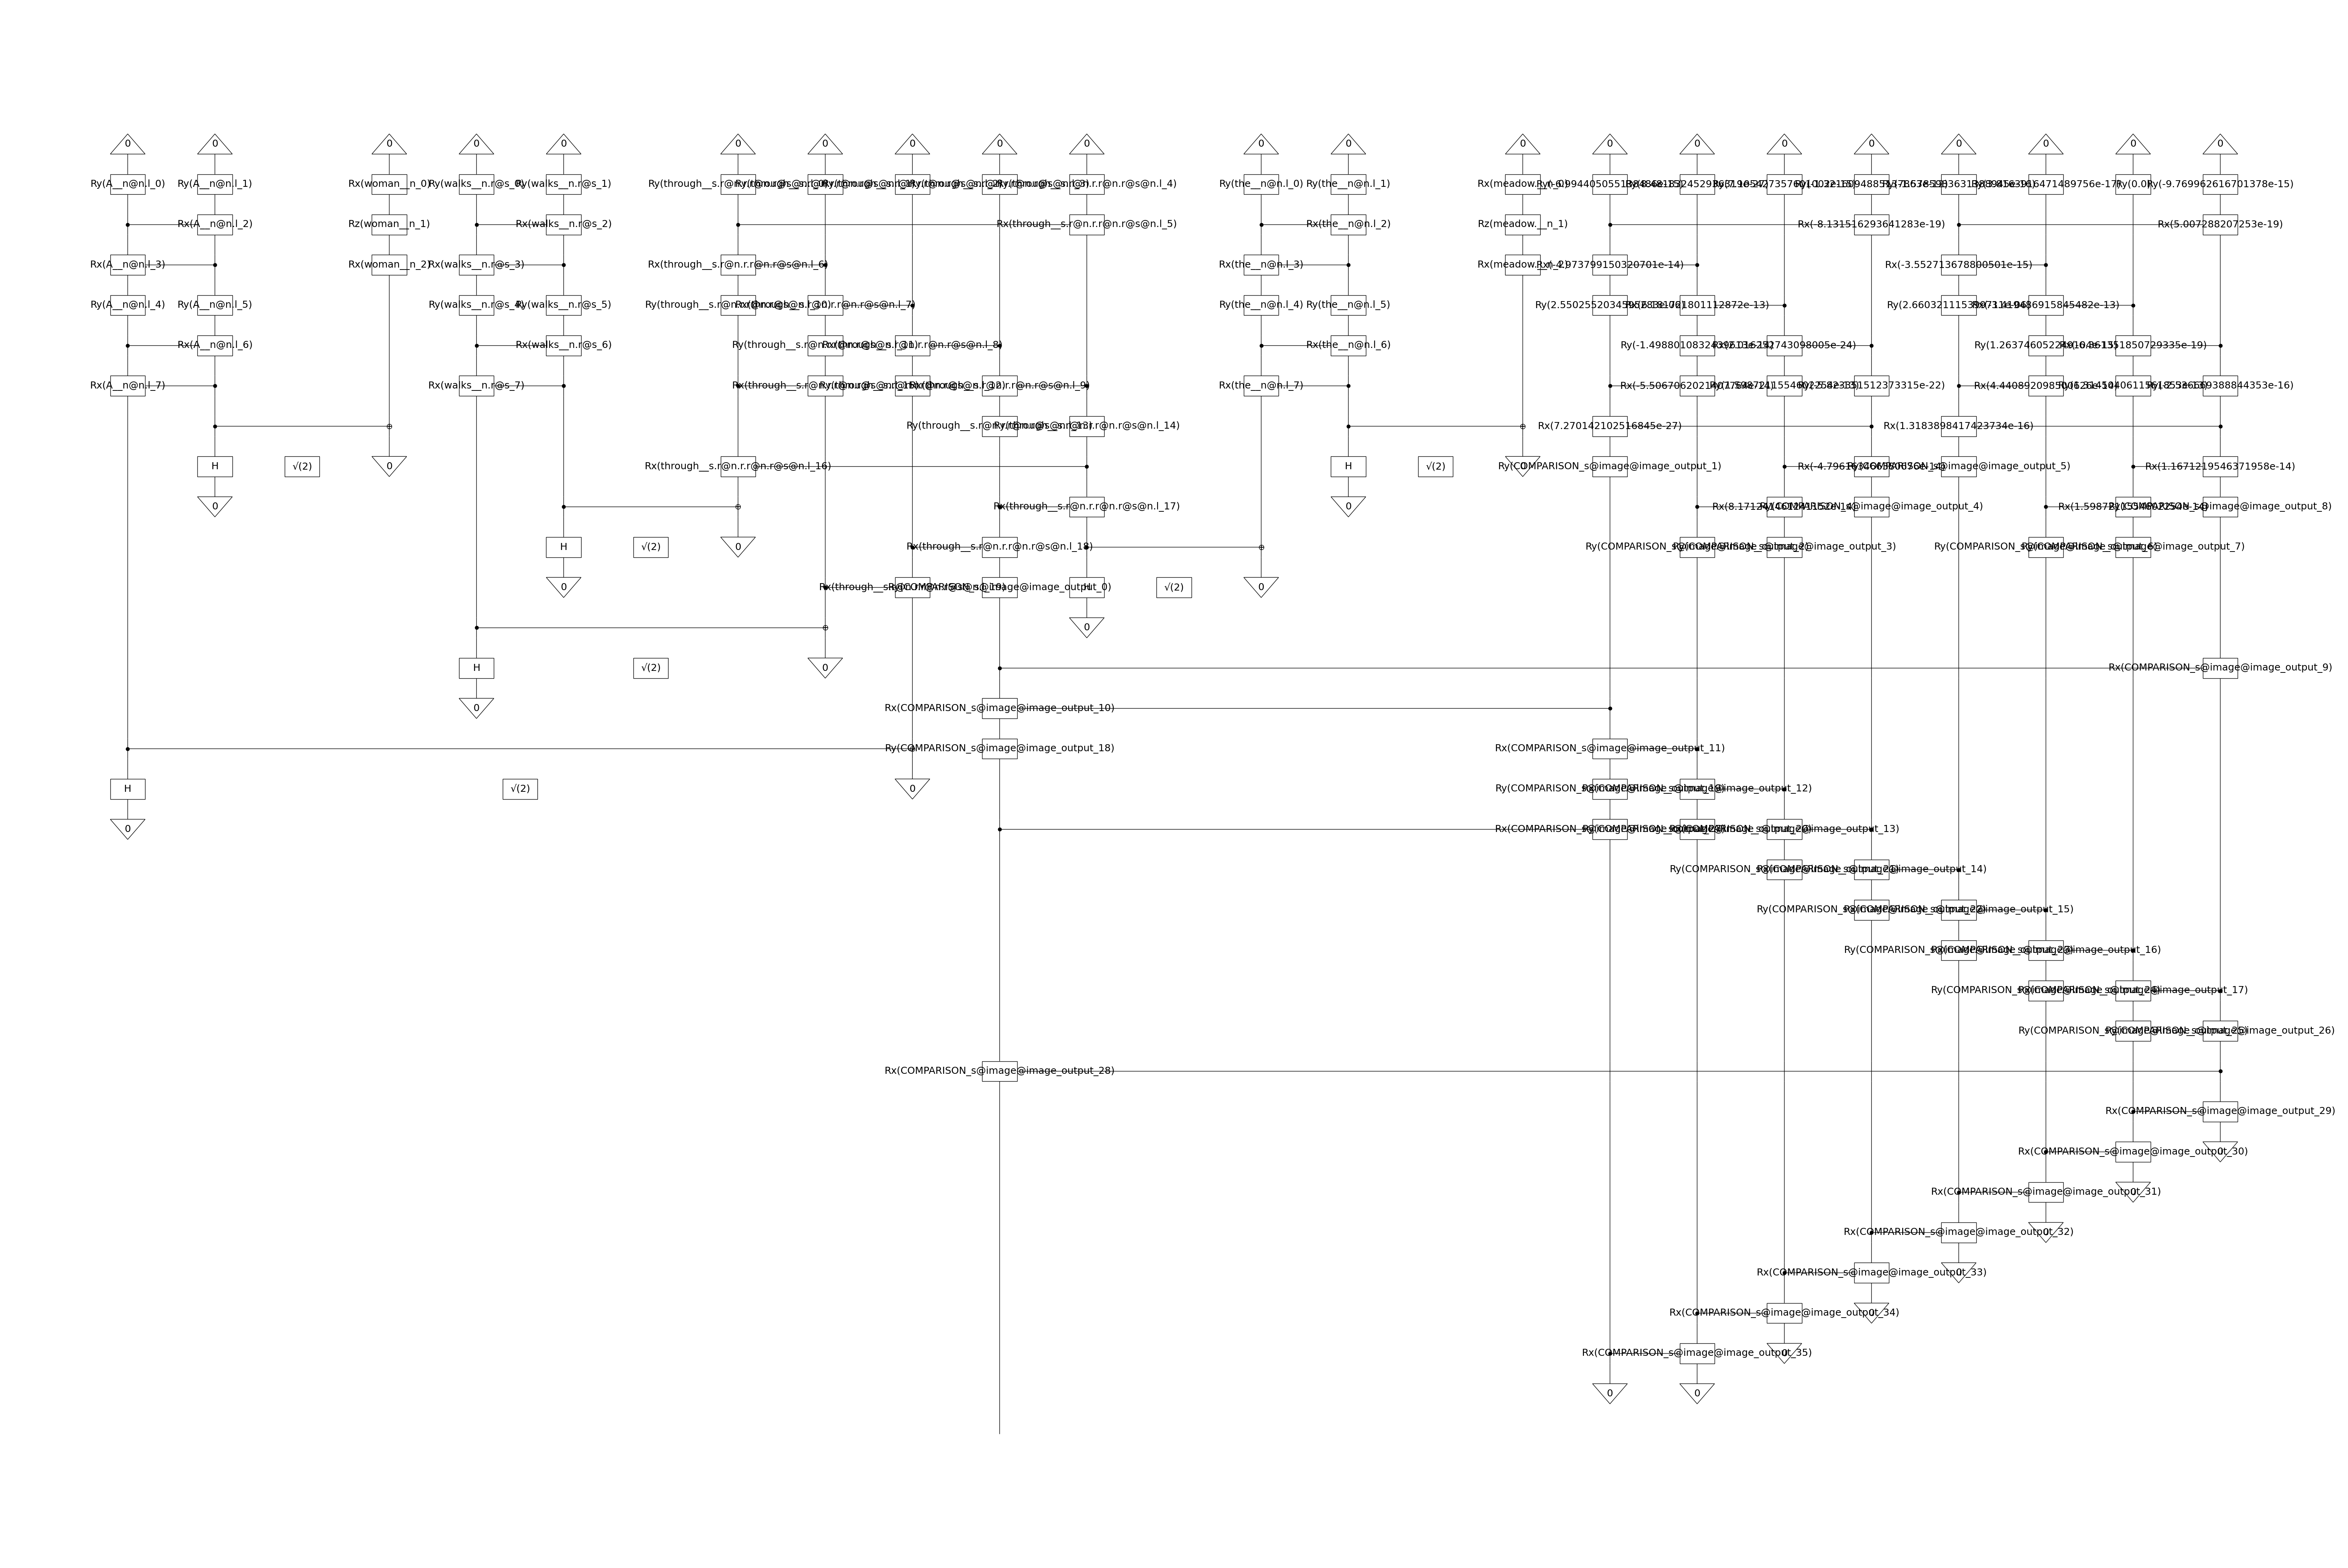

In [77]:
import sympy as sp

# Create new Type
image_type = Ty("image")
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1)
diagram = (sentence_diagram @ image_type @ image_type) >> comparison_box  # Sentence digarm and comparison box is in grammar form
print("Template diagram : (sentence, image1, image2)")
temp_diagram.draw(figsize=(20, 10), fontsize=12)

# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)
temp_circuit = ansatz(diagram)
print("Template circuit : (sentence, image_type , image_type)")
temp_circuit.draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )

image_1 = conc_image_circ_pos
image_2 = conc_image_circ_neg

final_circuit = (image_1 @ image_2) >> circuit
print("Quantum circuit : (sentence, image data pos , image data neg)")
final_circuit.draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )
